In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors.nearest_centroid import NearestCentroid

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

## Importing the data

In [2]:
data = pd.read_csv("neonatal_basic_data.csv")
training_set = data[data['death']!=0]
training_labels = training_set['death']
training_data = training_set[['ga', 'bw']]
test_set = data[data['death']==0]
#test_labels = test_set['death']
test_data = test_set[['ga', 'bw']]

### Scaling the data

In [3]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

## Visualization of the class distribution

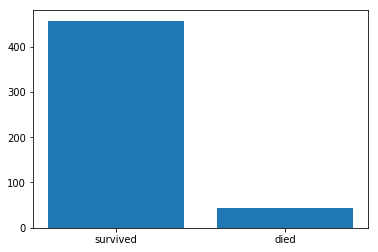

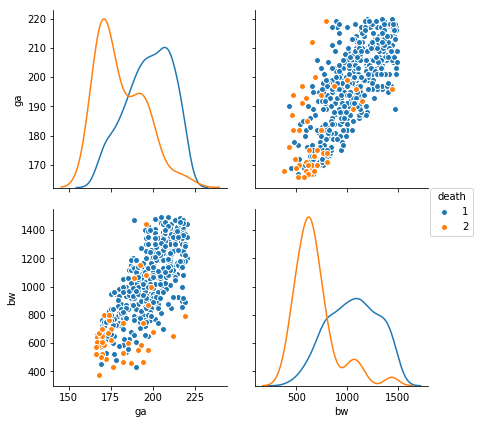

In [4]:
labels = training_labels.as_matrix()
classes, distribution = np.unique(labels, return_counts=True)
plt.bar(classes, distribution)
plt.xticks(classes, ["survived", "died"])
plt.show()

sns.pairplot(training_set[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )

plt.show()

<Figure size 695.52x432 with 0 Axes>

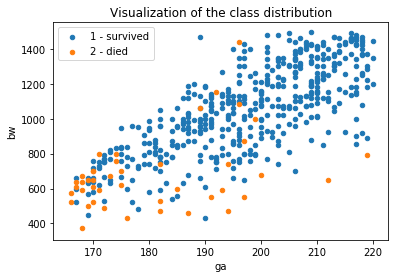

In [5]:
c = sns.color_palette()

fig = plt.figure(figsize=(1.61 * 6, 6))
ax = training_set.loc[training_set['death'] == 1].plot(x='ga', y='bw',  kind='scatter', color=c[0], label='1 - survived')
training_set.loc[training_set['death'] == 2].plot(x='ga', y='bw',  kind='scatter', ax=ax, color=c[1], label='2 - died')
plt.title('Visualization of the class distribution')
plt.savefig('raw_vis.png', dpi=300,bbox_inches='tight')

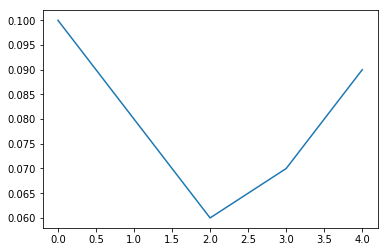

Average k-fold cross validation error: 0.08


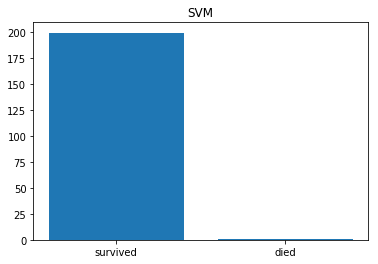

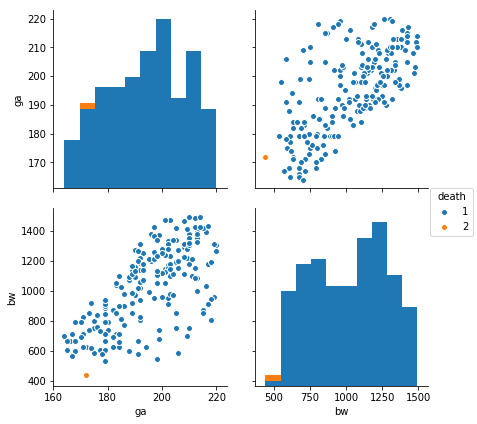

In [6]:
#clf = svm.SVC(class_weight='balanced', kernel='rbf')#, degree=3, coef0=)
#clf = DecisionTreeClassifier()
clf = LogisticRegression()
#clf = GaussianNB()

#print('score for SVM: ', clf.score(training_data_stand, training_labels))
#print('f1 measure for SVM: ', f1_score(training_labels, clf.predict(training_data_stand),
#                                                  average='weighted'))
errs = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(training_data_stand):
    X_train, X_test = training_data_stand[train_index], training_data_stand[test_index]
    y_train, y_test = training_labels[train_index], training_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
    errs.append(mse)
plt.plot(range(5), errs)
plt.show()
print("Average k-fold cross validation error:", np.mean(errs))

clf.fit(training_data_stand, training_labels)
p = clf.predict(test_data_stand)

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

svm_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(svm_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             #, diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Decision Trees

In [7]:
classifier = DecisionTreeClassifier()
classifier = classifier.fit(training_data_stand, training_labels)
print('score for decision trees: ', classifier.score(training_data_stand, training_labels))
print('f1 measure for decision trees: ', f1_score(training_labels, classifier.predict(training_data_stand),
                                                  average='weighted'))
p = classifier.predict(test_data_stand)

score for decision trees:  0.998
f1 measure for decision trees:  0.9979893281902925


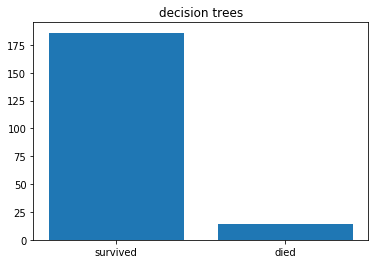

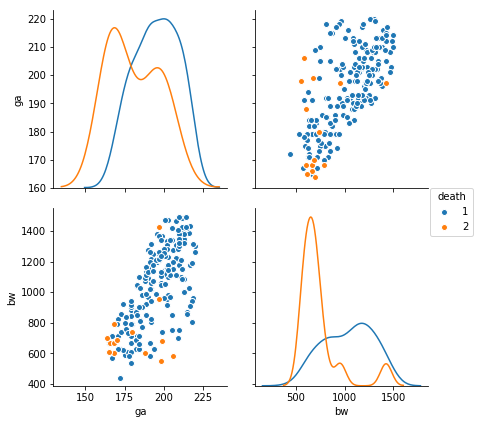

In [8]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('decision trees')
plt.xticks(classes, ["survived", "died"])
plt.show()

dt_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(dt_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### SVM

In [9]:
SVM = svm.SVC(class_weight='balanced', kernel='rbf')
SVM.fit(training_data_stand, training_labels)
print('score for SVM: ', SVM.score(training_data_stand, training_labels))
print('f1 measure for SVM: ', f1_score(training_labels, SVM.predict(training_data_stand),
                                                  average='weighted'))
p = SVM.predict(test_data_stand)

score for SVM:  0.856
f1 measure for SVM:  0.8796950654978825


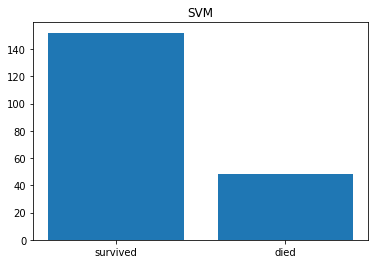

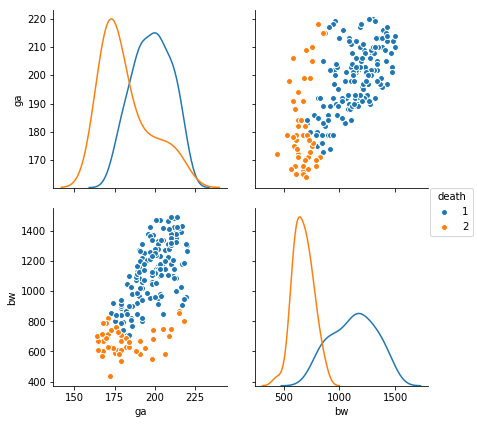

In [10]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

svm_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(svm_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Naive Bayes

In [11]:
GNB = GaussianNB()
GNB.fit(training_data_minmax, training_labels)
print('score for logistic regression: ', GNB.score(training_data_minmax, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, GNB.predict(training_data_minmax),
                                                  average='weighted'))
p = GNB.predict(test_data_minmax)

score for logistic regression:  0.892
f1 measure for logistic regression:  0.8995084501506617


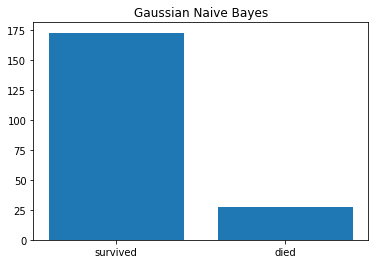

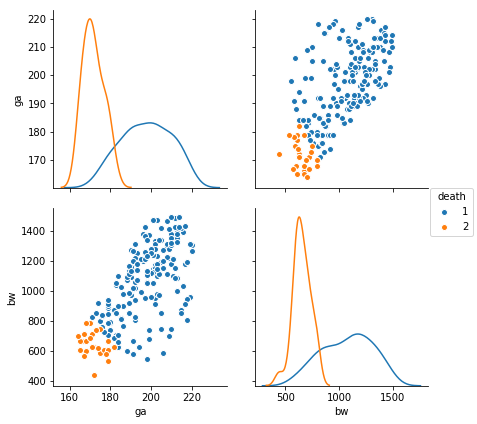

In [12]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Naive Bayes')
plt.xticks(classes, ["survived", "died"])
plt.show()

gnb_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gnb_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Gaussian Processes

In [13]:
kernel = 1.0 * RBF(length_scale=1.0)
gp = GaussianProcessClassifier(kernel=kernel, optimizer=None)
gp.fit(training_data, training_labels)
p = gp.predict(test_data)

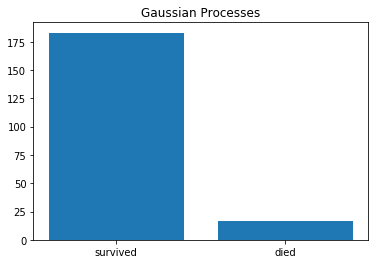

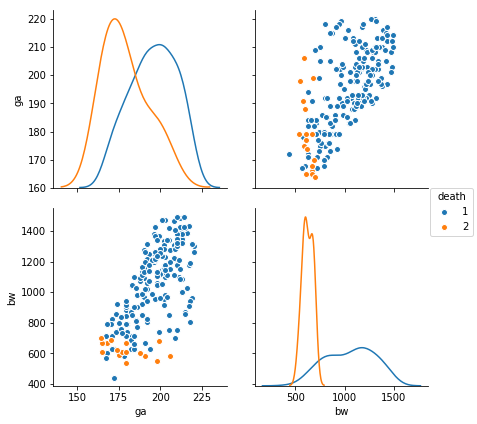

In [14]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Processes')
plt.xticks(classes, ["survived", "died"])
plt.show()

gp_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gp_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

## Mixing prediction
Final prediction are:
    - Survived: if all the models agree that the patient survived
    - Died: if at least one of the model classify the patient as died

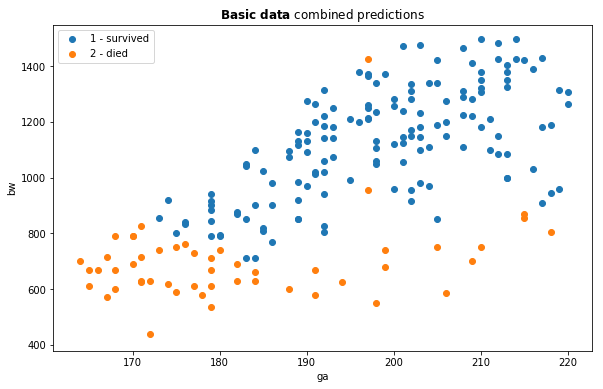

In [15]:
pred = pd.DataFrame(data={'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix()
    , 'death_dt':dt_pred['death'], 'death_svm':svm_pred['death']
    , 'death_gnb':gnb_pred['death'], 'death_gp':gp_pred['death']})

died = pred.loc[(pred['death_dt'] == 2) | (pred['death_svm']==2) | (pred['death_gp'] == 2) | (pred['death_gnb']==2)]
survived = pred.loc[(pred['death_dt'] == 1) & (pred['death_svm']==1) & (pred['death_gp'] == 1) & (pred['death_gnb'] == 1)]
plt.figure(figsize=(1.61 * 6, 6))
plt.scatter(survived['ga'], survived['bw'], label='1 - survived')
plt.scatter(died['ga'], died['bw'], label='2 - died')
plt.legend()
plt.xlabel('ga')
plt.ylabel('bw')
plt.title(r'$\bf{Basic}$ $\bf{data}$ combined predictions')
plt.savefig('basic_data_combined.png', dpi=300,bbox_inches='tight')
plt.show()

## Time-series data classification

In [16]:
ts = pd.read_csv("timeseries.csv", names=['patientid','mean ABP_S','var ABP_S','slope ABP_S','intercept ABP_S','mean ABP_M','var ABP_M','slope ABP_M','intercept ABP_M','mean ABP_D','var ABP_D','slope ABP_D','intercept ABP_D','mean HR_ECG','var HR_ECG','slope HR_ECG','intercept HR_ECG','mean SpO2','var SpO2','slope SpO2','intercept SpO2'])
training_data = ts[ts['patientid'].isin(data[data['death']!=0]['patientid'])]
training_data.drop(['patientid'], axis=1)
test_data = ts[ts['patientid'].isin(data[data['death']==0]['patientid'])]
test_data.drop(['patientid'], axis=1)
ts.shape

(700, 21)

In [17]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

## Evaluation of classifier via K-fold cross-validation

In [94]:
#for kernel in ['poly', 'rbf', 'linear', 'sigmoid']:
    #for gamma in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]:
        #for degree in range(2,10):
clf = svm.SVC(class_weight='balanced', kernel='rbf', gamma=0.07, degree=5)
#clf = DecisionTreeClassifier()
#clf = LogisticRegression()
#clf = GaussianNB()

#print('score for SVM: ', clf.score(training_data_stand, training_labels))
#print('f1 measure for SVM: ', f1_score(training_labels, clf.predict(training_data_stand),
#                                                  average='weighted'))
errs = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(training_data_stand):
    X_train, X_test = training_data_stand[train_index], training_data_stand[test_index]
    y_train, y_test = training_labels[train_index], training_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
    errs.append(mse)
#plt.plot(range(5), errs)
#plt.show()
print(kernel, gamma, degree, "Average k-fold cross validation error:", np.mean(errs))

clf.fit(training_data_stand, training_labels)
p = clf.predict(test_data_stand)

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

svm_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(svm_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()


NameError: name 'gamma' is not defined

In [72]:
clf = svm.SVC(class_weight='balanced', kernel='rbf'):#, gamma=0.07, degree=5)

#print('score for SVM: ', clf.score(training_data_stand, training_labels))
#print('f1 measure for SVM: ', f1_score(training_labels, clf.predict(training_data_stand),
#                                                  average='weighted'))

clf.fit(training_data_stand, training_labels)
p = clf.predict(test_data_stand)

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

svm_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(svm_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

SyntaxError: invalid syntax (<ipython-input-72-8b3bdf866e73>, line 1)

### Decision Trees

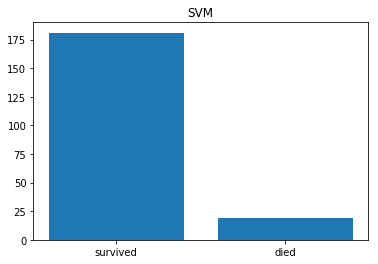

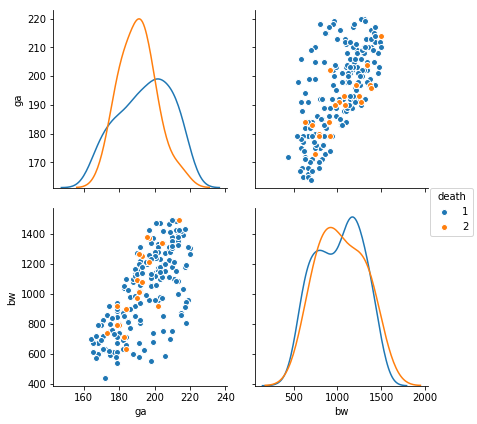

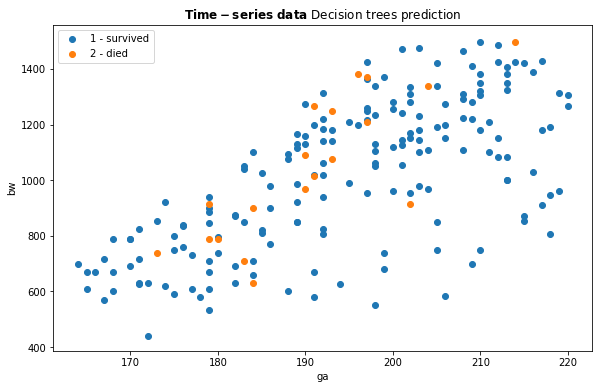

In [18]:
clf = DecisionTreeClassifier()

#print('score for SVM: ', clf.score(training_data_stand, training_labels))
#print('f1 measure for SVM: ', f1_score(training_labels, clf.predict(training_data_stand),
#                                                  average='weighted'))

clf.fit(training_data_stand, training_labels)
p = clf.predict(test_data_stand)

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

dt_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(dt_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

died = dt_pred.loc[(dt_pred['death'] == 2)]
survived = dt_pred.loc[(dt_pred['death'] == 1)]

plt.figure(figsize=(1.61 * 6, 6))
plt.scatter(survived['ga'], survived['bw'], label='1 - survived')
plt.scatter(died['ga'], died['bw'], label='2 - died')
plt.legend()
plt.xlabel('ga')
plt.ylabel('bw')
plt.title(r'$\bf{Time-series}$ $\bf{data}$ Decision trees prediction')
plt.savefig('ts_data_DT.png', dpi=300,bbox_inches='tight')
plt.show()

### SVM

score for SVM:  0.748
f1 measure for SVM:  0.8018650000000002


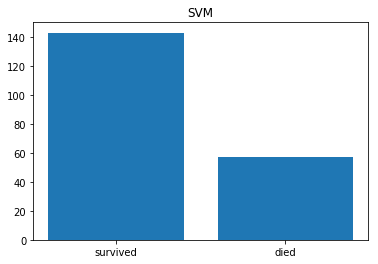

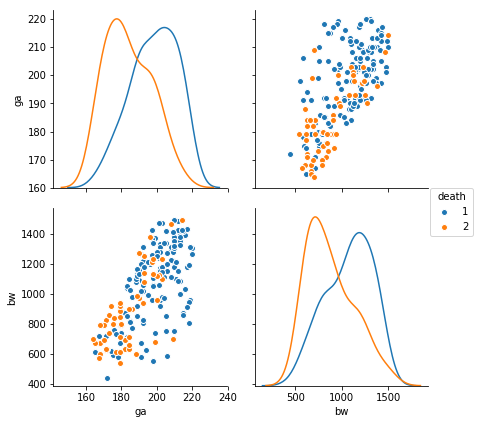

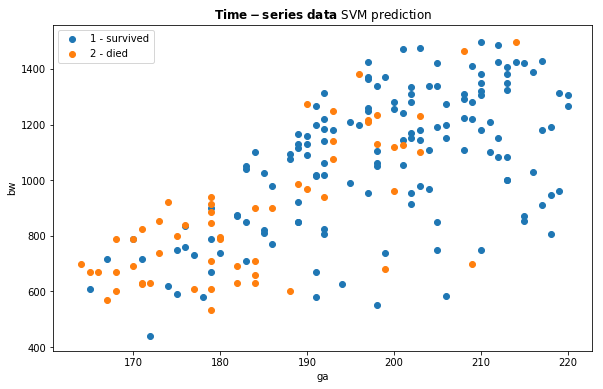

In [22]:
SVM = svm.SVC(class_weight='balanced', kernel='rbf')
SVM.fit(training_data_stand, training_labels)
print('score for SVM: ', SVM.score(training_data_stand, training_labels))
print('f1 measure for SVM: ', f1_score(training_labels, SVM.predict(training_data_stand),
                                                  average='weighted'))
p = SVM.predict(test_data_stand)

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

svm_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(svm_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

died = svm_pred.loc[(svm_pred['death'] == 2)]
survived = svm_pred.loc[(svm_pred['death'] == 1)]

plt.figure(figsize=(1.61 * 6, 6))
plt.scatter(survived['ga'], survived['bw'], label='1 - survived')
plt.scatter(died['ga'], died['bw'], label='2 - died')
plt.legend()
plt.xlabel('ga')
plt.ylabel('bw')
plt.title(r'$\bf{Time-series}$ $\bf{data}$ SVM prediction')
plt.savefig('ts_data_SVM.png', dpi=300,bbox_inches='tight')
plt.show()

### Naive Bayes

score for logistic regression:  0.524
f1 measure for logistic regression:  0.6177132458078772


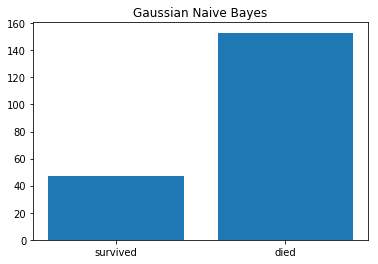

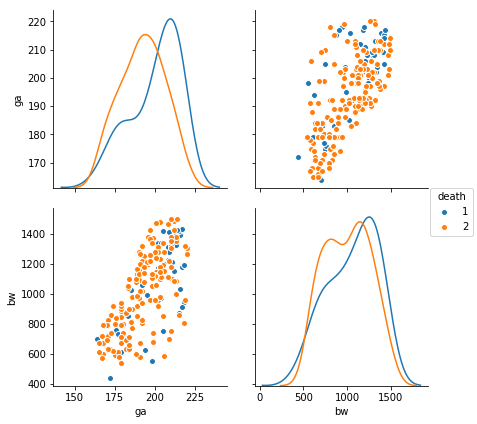

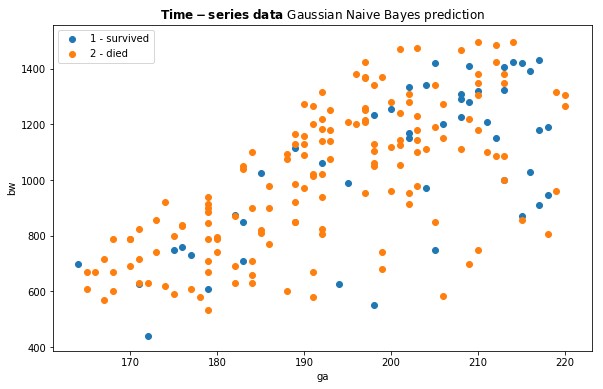

In [24]:
GNB = GaussianNB()
GNB.fit(training_data_minmax, training_labels)
print('score for logistic regression: ', GNB.score(training_data_minmax, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, GNB.predict(training_data_minmax),
                                                  average='weighted'))
p = GNB.predict(test_data_minmax)

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Naive Bayes')
plt.xticks(classes, ["survived", "died"])
plt.show()

gnb_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gnb_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

died = gnb_pred.loc[(gnb_pred['death'] == 2)]
survived = gnb_pred.loc[(gnb_pred['death'] == 1)]

plt.figure(figsize=(1.61 * 6, 6))
plt.scatter(survived['ga'], survived['bw'], label='1 - survived')
plt.scatter(died['ga'], died['bw'], label='2 - died')
plt.legend()
plt.xlabel('ga')
plt.ylabel('bw')
plt.title(r'$\bf{Time-series}$ $\bf{data}$ Gaussian Naive Bayes prediction')
plt.savefig('ts_data_GNB.png', dpi=300,bbox_inches='tight')
plt.show()

### Gaussian Processes

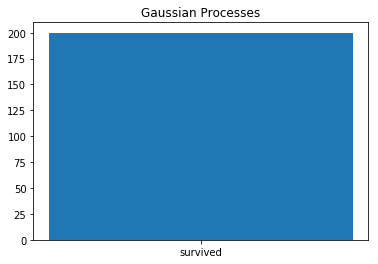

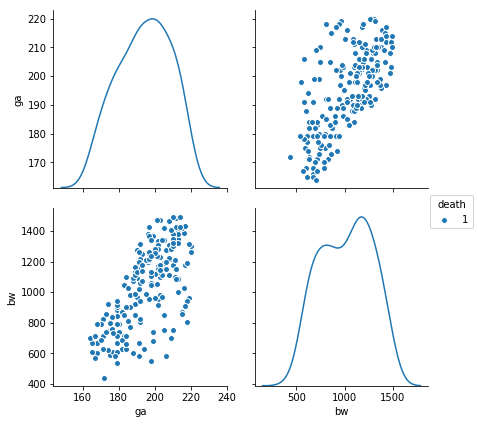

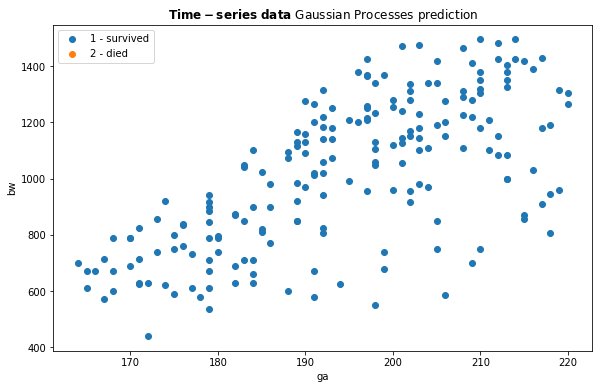

In [26]:
kernel = 1.0 * RBF(length_scale=1.0)
gp = GaussianProcessClassifier(kernel=kernel, optimizer=None)
gp.fit(training_data, training_labels)
p = gp.predict(test_data)

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Processes')
plt.xticks(classes, ["survived", "died"])
plt.show()

gp_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gp_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

died = gp_pred.loc[(gp_pred['death'] == 2)]
survived = gp_pred.loc[(gp_pred['death'] == 1)]

plt.figure(figsize=(1.61 * 6, 6))
plt.scatter(survived['ga'], survived['bw'], label='1 - survived')
plt.scatter(died['ga'], died['bw'], label='2 - died')
plt.legend()
plt.xlabel('ga')
plt.ylabel('bw')
plt.title(r'$\bf{Time-series}$ $\bf{data}$ Gaussian Processes prediction')
plt.savefig('ts_data_GP.png', dpi=300,bbox_inches='tight')
plt.show()

### Logistic Regression

In [98]:
LogReg = LogisticRegression()
LogReg.fit(training_data_stand, training_labels)
print('score for logistic regression: ', LogReg.score(training_data_stand, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, LogReg.predict(training_data_stand),
                                                  average='weighted'))
p = LogReg.predict(test_data_stand)

score for logistic regression:  0.916
f1 measure for logistic regression:  0.8844264705882352


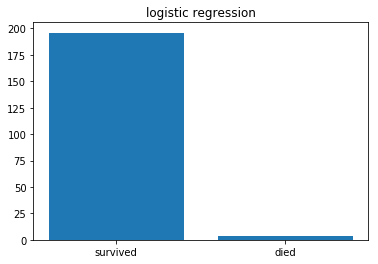

In [99]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('logistic regression')
plt.xticks(classes, ["survived", "died"])
plt.show()

In [40]:
kernel = RBF(length_scale=1.0) #+ RBF(length_scale=2.0) + RBF(length_scale=5.0)
gp = GaussianProcessClassifier(kernel=kernel, optimizer=None)
gp.fit(training_data_stand, training_labels)
p = gp.predict(test_data_stand)

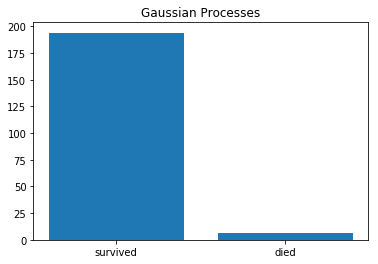

In [41]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Processes')
plt.xticks(classes, ["survived", "died"])
plt.show()

gp_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gp_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

In [43]:
#for delta in np.arange(0,10,0.2):
clf = NearestCentroid()#shrink_threshold=0.2)
clf.fit(training_data_stand, training_labels)
#for i in range(test_data_stand.shape[0]):
#    for j in range(test_data_stand.shape[1]):
#        if np.isinf(test_data_stand[i,j]):
#            print("inf")
p = clf.predict(test_data_stand)

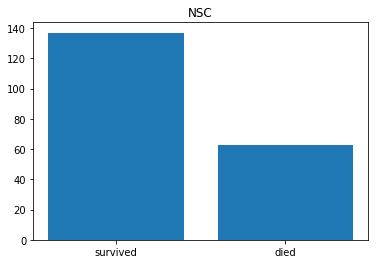

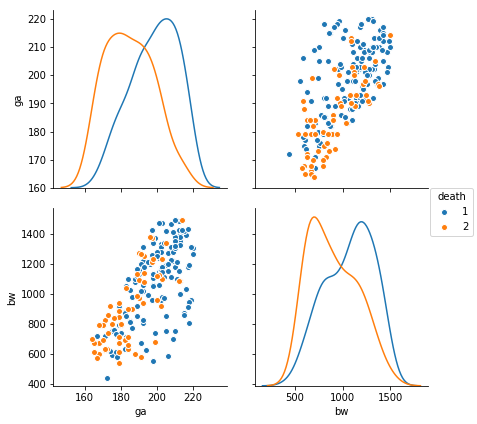

In [44]:

classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('NSC')
plt.xticks(classes, ["survived", "died"])
plt.show()

nsc_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                         'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(nsc_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

# Combining time-series with basic data

In [74]:
# ts, data
fulldata = data.merge(ts, on='patientid')
training_set = fulldata[fulldata['death']!=0]
training_labels = training_set['death']
training_data = training_set.drop(['patientid', 'death'], axis=1)
test_set = fulldata[fulldata['death']==0]
test_data = test_set.drop(['patientid', 'death'], axis=1)

In [75]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

In [76]:
classifier = DecisionTreeClassifier()
classifier = classifier.fit(training_data_stand, training_labels)
print('score for decision trees: ', classifier.score(training_data_stand, training_labels))
print('f1 measure for decision trees: ', f1_score(training_labels, classifier.predict(training_data_stand),
                                                  average='weighted'))
p = classifier.predict(test_data_stand)

('score for decision trees: ', 1.0)
('f1 measure for decision trees: ', 1.0)


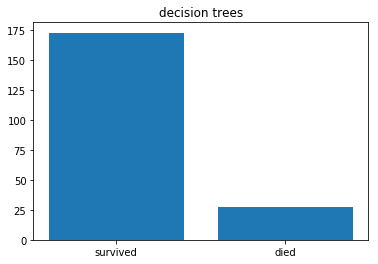

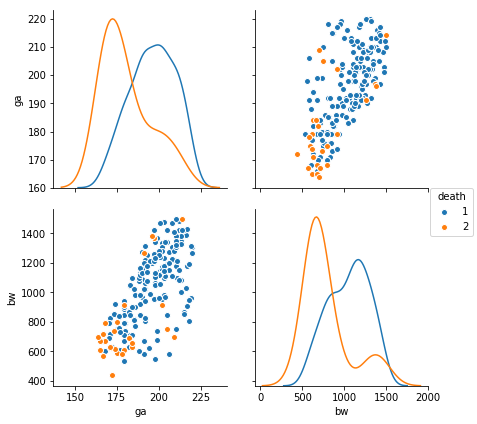

In [77]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('decision trees')
plt.xticks(classes, ["survived", "died"])
plt.show()

dt_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(dt_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

In [78]:
SVM = svm.SVC(class_weight='balanced', kernel='rbf')
SVM.fit(training_data_stand, training_labels)
print('score for SVM: ', SVM.score(training_data_stand, training_labels))
print('f1 measure for SVM: ', f1_score(training_labels, SVM.predict(training_data_stand),
                                                  average='weighted'))
p = SVM.predict(test_data_stand)

('score for SVM: ', 0.85199999999999998)
('f1 measure for SVM: ', 0.87872733413158943)


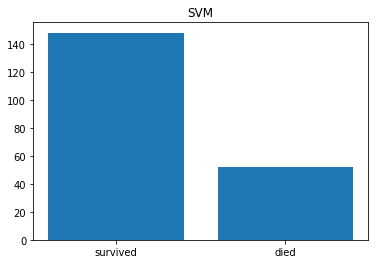

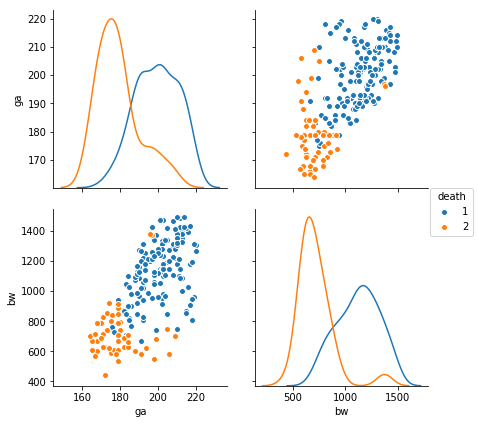

In [79]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

svm_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(svm_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

In [80]:
kernel = RBF(length_scale=1.0) #+ RBF(length_scale=2.0) + RBF(length_scale=5.0)
gp = GaussianProcessClassifier(kernel=kernel, optimizer=None)
gp.fit(training_data_stand, training_labels)
p = gp.predict(test_data_stand)

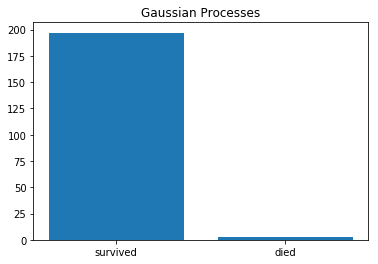

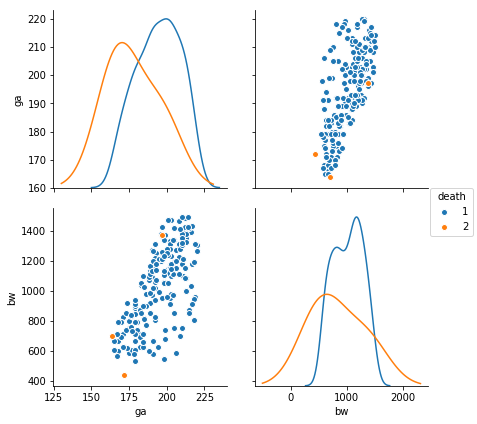

In [81]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Processes')
plt.xticks(classes, ["survived", "died"])
plt.show()

gp_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gp_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

In [83]:
GNB = GaussianNB()
GNB.fit(training_data_minmax, training_labels)
print('score for logistic regression: ', GNB.score(training_data_minmax, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, GNB.predict(training_data_minmax),
                                                  average='weighted'))
p = GNB.predict(test_data_minmax)

('score for logistic regression: ', 0.66800000000000004)
('f1 measure for logistic regression: ', 0.74084467607230864)


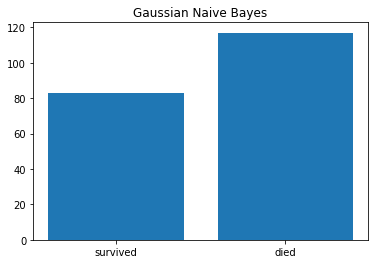

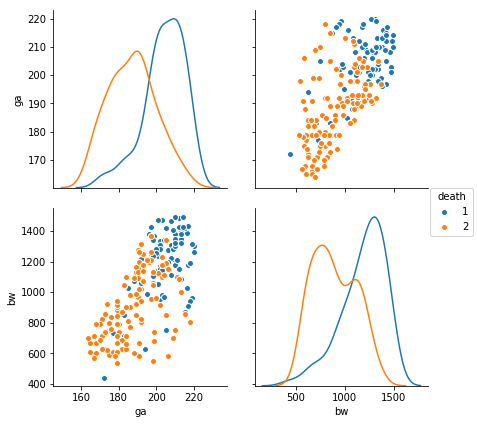

In [84]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Naive Bayes')
plt.xticks(classes, ["survived", "died"])
plt.show()

gnb_pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
sns.pairplot(gnb_pred[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

In [85]:
LogReg = LogisticRegression()
LogReg.fit(training_data_stand, training_labels)
print('score for logistic regression: ', LogReg.score(training_data_stand, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, LogReg.predict(training_data_stand),
                                                  average='weighted'))
p = LogReg.predict(test_data_stand)

('score for logistic regression: ', 0.92200000000000004)
('f1 measure for logistic regression: ', 0.90871921532753996)


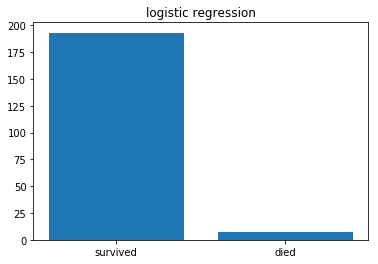

In [86]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('logistic regression')
plt.xticks(classes, ["survived", "died"])
plt.show()

In [ ]:
pred = pd.DataFrame(data={'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix()
    , 'death_dt':dt_pred['death'], 'death_svm':svm_pred['death']
    , 'death_gnb':gnb_pred['death'], 'death_gp':gp_pred['death']})

died = pred.loc[(pred['death_dt'] == 2) | (pred['death_svm']==2) | (pred['death_gp'] == 2) | (pred['death_gnb']==2)]
survived = pred.loc[(pred['death_dt'] == 1) & (pred['death_svm']==1) & (pred['death_gp'] == 1) & (pred['death_gnb'] == 1)]
plt.figure(figsize=(6,10))
plt.scatter(survived['ga'], survived['bw'])
plt.scatter(died['ga'], died['bw'])
plt.show()